Requirements:
- Some notion of distance
- An assumption that points that are close to one another are similar

Characteristics:
- Consciously neglects a lot of information since prediction for each new point depends only on the handful of points closest to it.
- It also doesn't help you to understand the drivers of whatever phenomenon you're looking at.

In [1]:
from IPython.core import debugger as dbg

In [2]:
#<<export>>
from typing import List
from collections import Counter

In [3]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

In [4]:
votes='a b c b'.split()
raw_majority_vote(votes)

'b'

Options if we have a ties:
- pick one of the winners at random
- weight the votes by distance and pick the weighted winner
- reduce k until we find a unique winner

In [5]:
def majority_vote(labels: List[str]) -> str:
    """Assuming labels are ordered from nearest to the fartherst."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    # see how many winners we have by matching counts to the highest value
    num_winners = len([count
                      for count in vote_counts.values()
                      if count == winner_count])
    if num_winners == 1:
        return winner # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest
    
    

In [6]:
votes = 'a b b b c b a a a'.split()
majority_vote(votes)

'b'

# Creates a classifier

In [7]:
from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

In [8]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str
        
def knn_classify(k: int,
                labeled_points: List[LabeledPoint],
                new_point: Vector) -> str:
    
    # Order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                        key=lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    
    # and let them vote
    return majority_vote(k_nearest_labels)

### Getting data

- sepal_length, sepal_width, petal_length, petal_width, class


In [9]:
import requests

In [10]:
data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

In [11]:
# !mv data/iris.dat data/iris.data

In [12]:
with open('data/iris.data','w') as f:
    f.write(data.text)

In [13]:
from typing import Dict
import csv
from collections import defaultdict

In [14]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """sepal_length, sepal_width, petal_length, petal_width, class"""
    if row:
        measurements = [float(value) for value in row[:-1]]
        # class is "Iris-virginica"; we just want "virginica"
        label = row[-1].split("-")[1]
        return LabeledPoint(measurements, label)

In [15]:
with open('data/iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if row]

In [16]:
iris_data[-3:]

[LabeledPoint(point=[6.5, 3.0, 5.2, 2.0], label='virginica'),
 LabeledPoint(point=[6.2, 3.4, 5.4, 2.3], label='virginica'),
 LabeledPoint(point=[5.9, 3.0, 5.1, 1.8], label='virginica')]

In [17]:
#group by label
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

In [18]:
lst0='sepal_length,sepal_width,petal_length,petal_width'.split(',')
dct_dim={v:n for n,v in enumerate(lst0)}
dct_dim

{'sepal_length': 0, 'sepal_width': 1, 'petal_length': 2, 'petal_width': 3}

In [19]:
setosa = points_by_species['setosa']

In [20]:
import plotly.express as px

In [21]:
def get_dimension(vectors,dim):
    return [lst[dim] for lst in vectors]

In [22]:
# sepal_length=[lst[dct_dim['sepal_length']] for lst in setosa]
sepal_length=get_dimension(setosa,dct_dim['sepal_length'])
sepal_width=get_dimension(setosa,dct_dim['sepal_width'])

In [23]:
from matplotlib import pyplot as plt
metrics = list(dct_dim.keys())
metrics

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [24]:
for i in range(4):
    for j in range(4):
        if j > i:
            print((i,j))

(0, 1)
(0, 2)
(0, 3)
(1, 2)
(1, 3)
(2, 3)


In [25]:
metrics = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
pairs =[ (i,j) for i in range(4) for j in range(4) if i < j] #build scaffle
marks = ['+','.','x'] # we have 3 classes, so 3 markers


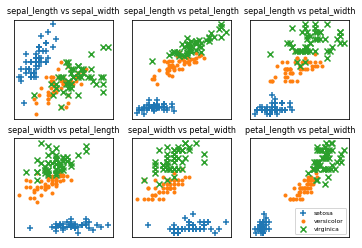

In [26]:
fig, ax = plt.subplots(2,3)
from IPython.core import debugger as dbg

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col] # pick title
        ax[row][col].set_title(f'{metrics[i]} vs {metrics[j]}', fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
            
ax[-1][-1].legend(loc='lower right', prop={'size':6})
plt.show()


# Modeling

In [27]:
import random
from scratch.machine_learning import split_data

In [28]:
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

assert len(iris_train) == 0.7 * len(iris_data)
assert len(iris_test) == 0.3 * len(iris_data)

##### k is the number of neighbors who get to vote

In [29]:
from typing import Tuple

In [43]:
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str,str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        
    confusion_matrix[(predicted, actual)] += 1
    
pct_correct = num_correct / len(iris_test)


In [46]:
missed_matched="('virginica', 'versicolor'): 1 "
print(f'only 1 miss matched: {missed_matched}\n')
print(pct_correct, confusion_matrix)

only 1 miss matched: ('virginica', 'versicolor'): 1 

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


### The Curse of Dimensionality

- high-dimensional spaces are vast and they tend not to be close to one another at all.

In [48]:
random.random?

In [49]:
def random_point(dim: int) -> Vector:
    """ generate list of random floating points"""
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    """ find distances of random floating pairs"""
    return [distance(random_point(dim), random_point(dim))
           for _ in range(num_pairs)]

In [56]:
import tqdm
dimensions = range(1,101)

In [57]:
avg_distances = []
min_distances = []

In [60]:
random.seed(0)
num_of_random_pairs=10000

In [61]:
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, num_of_random_pairs)  
    avg_distances.append(sum(distances)/num_of_random_pairs) # track the average
    min_distances.append(min(distances)) # track the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


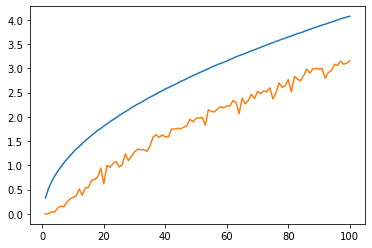

In [65]:
plt.plot(dimensions,avg_distances)
plt.plot(dimensions,min_distances)

In [66]:
# calculate the ratio between minimum and average
min_avg_ratio = [min_dist / avg_dist
                for min_dist, avg_dist in zip(min_distances, avg_distances)]

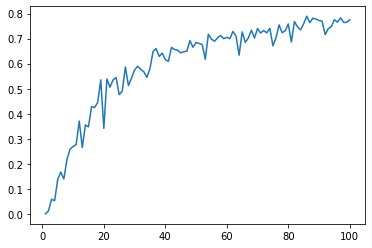

In [67]:
plt.plot(dimensions,min_avg_ratio)